In [227]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [228]:
def run_query(q):
    conn = sql.connect("chinook.db")
    return pd.read_sql(q,conn)
def run_command(c):
    conn = sql.connect("chinook.db")
    return conn.execute(c)
def show_tables():
    q = '''select name,type from sqlite_master 
    where type in ('table','view');'''
    return run_query(q)

In [229]:
show_tables()

name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table

In [230]:
q1 = '''WITH usa_track_sold AS 
            (SELECT * FROM invoice_line il
             inner join invoice i on i.invoice_id = il.invoice_id
             inner join customer c on c.customer_id = i.customer_id
             where c.country = 'USA')
    
     SELECT 
        ge.name genre_name,
        count(ust.invoice_line_id) track_sold,
        cast(count(ust.invoice_line_id) As float) / (select count(*) from usa_track_sold) perc_sold, 
        ar. name artist_name
        from usa_track_sold ust
        inner join track tr on tr.track_id = ust.track_id
        inner join genre ge on ge.genre_id = tr.genre_id
        inner join album al on al.album_id = tr.album_id
        inner join artist ar on ar.artist_id = al.artist_id
        group by 1 order by 2 desc limit 10'''   
run_query(q1)

genre_name  track_sold  perc_sold    artist_name
0                Rock         561   0.533777        The Who
1  Alternative & Punk         130   0.123692      Green Day
2               Metal         124   0.117983       Godsmack
3            R&B/Soul          53   0.050428  Amy Winehouse
4               Blues          36   0.034253      Buddy Guy
5         Alternative          35   0.033302  Chris Cornell
6               Latin          22   0.020932   Eric Clapton
7                 Pop          22   0.020932             U2
8         Hip Hop/Rap          20   0.019029  House Of Pain
9                Jazz          14   0.013321    Miles Davis

In [231]:
genre_sales_usa = run_query(q1)

In [232]:
genre_sales_usa.set_index('genre_name',drop = True,inplace = True)
genre_sales_usa

track_sold  perc_sold    artist_name
genre_name                                              
Rock                       561   0.533777        The Who
Alternative & Punk         130   0.123692      Green Day
Metal                      124   0.117983       Godsmack
R&B/Soul                    53   0.050428  Amy Winehouse
Blues                       36   0.034253      Buddy Guy
Alternative                 35   0.033302  Chris Cornell
Latin                       22   0.020932   Eric Clapton
Pop                         22   0.020932             U2
Hip Hop/Rap                 20   0.019029  House Of Pain
Jazz                        14   0.013321    Miles Davis

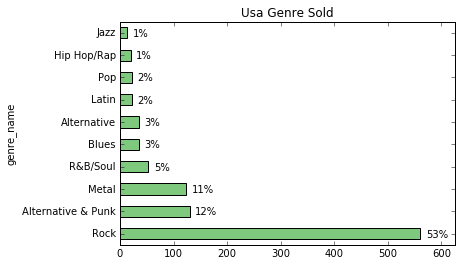

In [233]:
genre_sales_usa['track_sold'].plot.barh(title = 'Usa Genre Sold',
                                       xlim = (0,625), colormap = plt.cm.Accent)
for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label,'track_sold']
    label = (genre_sales_usa.loc[label,'perc_sold'] * 100).astype(int).astype(str) + '%'
    plt.annotate(str(label), (score + 10, i-0.15))


#### We can see tha top three genre based on the sales are Rock,Alternative & Punk and Metal. And top three artist are 'The Who', 'Green Day','Godsmack'.


In [234]:
q2 = '''WITH emp_sold AS (select i.customer_id, 
               sum(i.total) tota_sold,
               c.support_rep_id emp_id,
               e.first_name || ' ' || e.last_name emp_name,
               e.hire_date,
               e.country
               from invoice i
      inner join customer c on c.customer_id = i.customer_id
      inner join employee e on e.employee_id = c.support_rep_id 
      group by 1)
      
      Select es.emp_name,
             es.hire_date,
             sum(es.tota_sold) sum_emp_sold
             from emp_sold es
             group by 1
      
      '''
run_query(q2)

emp_name            hire_date  sum_emp_sold
0   Jane Peacock  2017-04-01 00:00:00       1731.51
1  Margaret Park  2017-05-03 00:00:00       1584.00
2  Steve Johnson  2017-10-17 00:00:00       1393.92

In [235]:
emp_total_sale = run_query(q2)
emp_total_sale.set_index('emp_name',drop = True ,inplace = True)

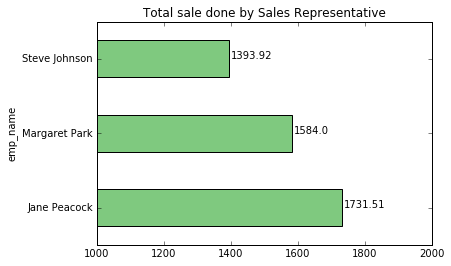

In [236]:
emp_total_sale['sum_emp_sold'].plot.barh(title = 'Total sale done by Sales Representative',
                                        xlim = (1000,2000),colormap = plt.cm.Accent) 

for i,label in enumerate(list(emp_total_sale.index)):
    score = emp_total_sale.loc[label,'sum_emp_sold']
    plt.annotate(score,(score + 5 ,i))

#### From above plot we can observe that Jane Peacock is having most sales . and if we took into consideration the date of hiring of the employee than we got to know that Sales made is directly proportional to the job ecpiereince.

In [237]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

country  customers  total_sales  average_order  \
0             USA         13      1040.49       7.942672   
1          Canada          8       535.59       7.047237   
2          Brazil          5       427.68       7.011148   
3          France          5       389.07       7.781400   
4         Germany          4       334.62       8.161463   
5  Czech Republic          2       273.24       9.108000   
6  United Kingdom          3       245.52       8.768571   
7        Portugal          2       185.13       6.383793   
8           India          2       183.15       8.721429   
9           Other         15      1094.94       7.448571   

   customer_lifetime_value  
0                80.037692  
1                66.948750  
2                85.536000  
3                77.814000  
4                83.655000  
5               136.620000  
6                81.840000  
7                92.565000  
8                91.575000  
9                72.996000

In [238]:
sales_by_country_new = run_query(sales_by_country)
sales_by_country_new.set_index("country",drop=True,inplace = True)


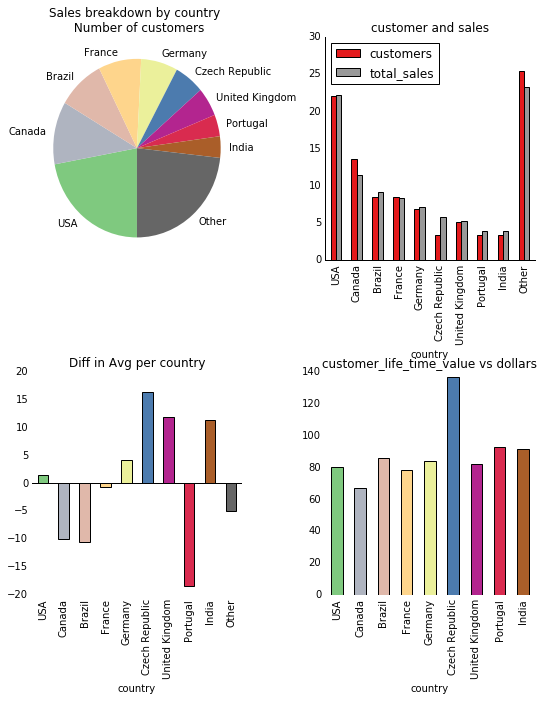

In [239]:
import numpy as np
colors = [plt.cm.Accent(i) for i in np.linspace(0,1,sales_by_country_new.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10)) 
ax1,ax2,ax3,ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.4)

#Pie chart
sales_breakdown_by_country = sales_by_country_new["total_sales"].copy().rename('')
sales_breakdown_by_country.plot.pie(ax=ax1,
                                    colormap= plt.cm.Accent,
                                    startangle = -90,
                                    counterclock = False,
                                    title = "Sales breakdown by country \n Number of customers",
                                    fontsize = 10,
                                    wedgeprops = {'linewidth': 0})

#Top right customer vs total sales bar chart
cvs_cols = ['customers','total_sales'] 
customer_vs_sales = sales_by_country_new[cvs_cols].copy()
for c in cvs_cols:
    customer_vs_sales[c]  /= customer_vs_sales[c].sum() / 100

customer_vs_sales.plot.bar(ax=ax2,
                           title = 'customer and sales',
                            colormap = plt.cm.Set1)
ax2.tick_params(bottom = False,top = False,left=False,right=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#Bottom left (Average order vs country)
avg_by_country = sales_by_country_new['average_order'].copy()
diff_from_avg = ((avg_by_country*100)/avg_by_country.mean()) - 100 
diff_from_avg.plot.bar(ax=ax3,
                       title = "Diff in Avg per country",
                       color = colors)

ax3.tick_params(top='off',bottom='off',left='off',right='off')
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.axhline(0,color = 'K')

#Bottom right (customer_lifetime_value vs country)

clt_cntry = sales_by_country_new['customer_lifetime_value'].copy()
clt_cntry  = clt_cntry.drop("Other")
clt_cntry.plot.bar(ax=ax4,
                  color = colors,
                  title="customer_life_time_value vs dollars")
ax4.tick_params(top='off',bottom='off',left='off',right='off')
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['right'].set_visible(False)








#### We can see from the above analysis that the Chech Republic has more opportunities to grow because there the no. of customers are less but the total sell is more and the customers are rich because the avg of order is more.

In [247]:
q4 = '''
     SELECT i.invoice_id,
            tr.album_id,
            count(il.track_id) track_count
     FROM invoice i
     INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id    
     INNER JOIN track tr ON tr.track_id = il.track_id
     group by 2'''

run_query(q4)

invoice_id  album_id  track_count
0           601         1           74
1           288         2            3
2           579         3            6
3           599         4           50
4           607         5           80
5           597         6           75
6           611         7           59
7           532         8           18
8           595         9           37
9           587        10           33
10          558        11           10
11          277        13            4
12          593        14           11
13          462        15            4
14          599        16           39
15          602        17           29
16          365        18            2
17          504        19            4
18          595        20           23
19          599        21            8
20          545        22            2
21          565        23           10
22          412        24            2
23          115        26            1
24          437        27            1
25          477        30           10
26           22        33            1
27          274        34            2
28          576        35            7
29          595        36           48
..          ...       ...          ...
221         557       259           21
222         577       260           31
223          29       261            1
224         331       262            3
225         566       264            3
226         523       265            6
227         311       266            3
228         260       267            3
229         360       268            3
230         558       269           11
231         600       270           50
232         515       271           15
233         180       277            1
234         486       278            5
235         421       279            1
236          96       280            1
237         579       293            8
238         189       302            1
239         441       304            2
240         565       305            8
241           4       314            1
242         437       318            3
243         613       321           50
244         586       322           47
245         548       323           10
246         586       325            1
247         111       329            1
248          59       336            1
249         517       339            8
250         428       344            2

[251 rows x 3 columns]